# NetVLAD Exploring

In [1]:
# Check if We have NVIDIA Driver Initialized 
!nvidia-smi

Fri Jun  9 09:42:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:03:00.0 Off |                  N/A |
|  0%   32C    P8               12W / 420W|      6MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import Stuffs
import os
import copy
import json
import numpy as np 
import PIL
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import shutil
import torchinfo
from torch.autograd import Variable
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, metrics

# Visualization
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from dateutil import tz
from datetime import datetime

2023-06-09 09:42:34.061872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:42:34.743965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Manual Seed
torch.manual_seed(777)

---

## NetVLAD Modules

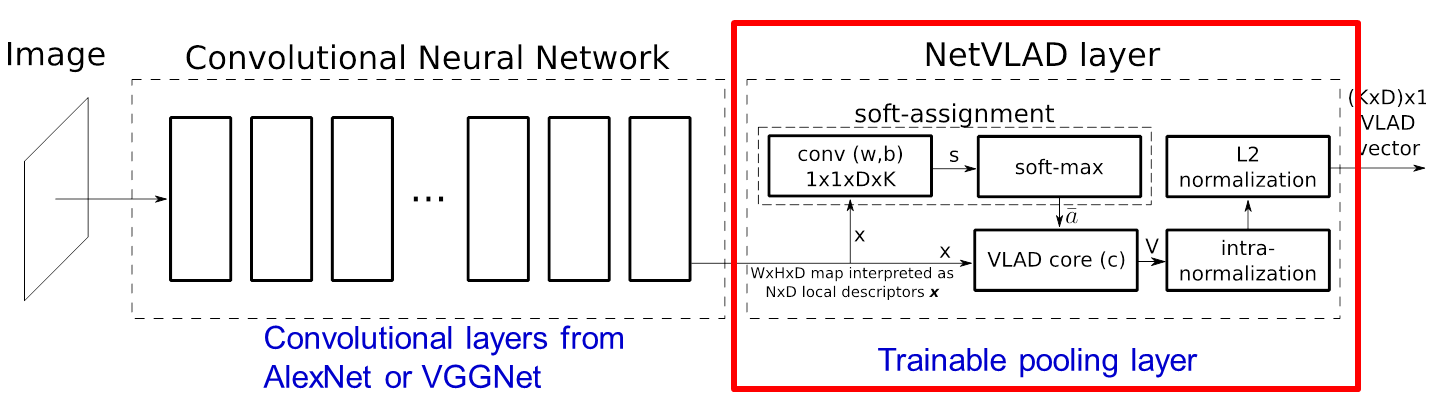

### NetVLAD Implementation

In [4]:
class NetVLAD(nn.Module):
    """
    NetVLAD Implementation
    """
    def __init__(self, 
            num_clusters=6,
            desc_dim=128,
            alpha=100.0,
            normalize_input=True,):
        # Initialize the Module
        super(NetVLAD, self).__init__()
        # Parameters
        self.num_clusters = num_clusters
        self.dim = desc_dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.DEBUG = False
        # Layers
        # Latent Convolution (add weight and bias to every latent)
        self.conv = nn.Conv2d(
            self.dim, 
            self.num_clusters, 
            kernel_size=(1, 1), 
            bias=True
        )
        # Where are those Centroids ?
        self.centroids = nn.Parameter(
            torch.rand(self.num_clusters, self.dim)
        )

        # Initialize Param
        self._init_params()
        
        # Prompt
        self.show_config()
    
    def show_config(self):
        """
        Show the Module settings
        """
        print("===========================================")
        print("NetVLAD Module initialized !")
        print("===========================================")        
        print(" - self.num_clusters : {}".format(self.num_clusters))
        print(" - self.dim : {}".format(self.dim))
        print(" - self.alpha : {}".format(self.alpha))
        print(" - self.normalize_input : {}".format(self.normalize_input))
        print("===========================================")
        
    def _init_params(self):
        """
        Initialize Parameters for Conv and Centroid
        """
        # Convolution Initialize Weight
        # Unsqueeze for Extend the dimension from ( K cluster, D-feature dimension ) = (K x D)
        # to (K x D x 1 x 1)
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        # Convolution Initialize Bias 
        self.conv.bias = nn.Parameter(
            -self.alpha * self.centroids.norm(dim=1)
        )
    
    def forward(self, x):
        """
        Forward Passing for NetVLAD Layer 
        input x -> Local Feature Description
        W*H*D map interpreted as NxD Local Descriptor "x"
        """
        # Store the Shape of first 2 dim (batch size, channels)
        BATCH_SIZE, CHANNEL = x.shape[0:2]
        # Decide to Normalize or not ?
        if self.normalize_input:
            # Normalize Across Descriptor Dim (across vector's components)
            x = F.normalize(x, p=2, dim=1)
        
        ################################################
        # Soft Assignment (A)
        ################################################
        soft_assignment = self.conv(x) # WkXi + Bk (output_shape = (cluster,W,H))
        # Readjust the shape to (N rows x K cluster x any)
        soft_assignment = soft_assignment.view(BATCH_SIZE, self.num_clusters, -1) # (Cluster x w*h)
        # Create result from group assignment -> a(x) (dim 1 mean in the row vec)
        soft_assignment = F.softmax(soft_assignment, dim=1)
        
        ################################################
        # Create VLAD Core
        ################################################
        # Create Flatten X (X which is directly comes from feature encoder)
        x_flatten = x.view(BATCH_SIZE, CHANNEL, -1) # (N x FeatureDim x (w*h))
        
        # Calculate Residual
        x_flatten_adjusted = x_flatten.expand(self.num_clusters, -1, -1, -1)
        x_flatten_adjusted = x_flatten_adjusted.permute(1,0,2,3)
        # Now X_Flatten_Adjusted Shape = ( torch.Size([1, 6, 128, 16]) )
        # = torch.Size([1, CLUSTER_SIZE , FEATURE_SIZE , (WxH) ])
        centroid_adjusted = self.centroids.expand(x_flatten.size(-1), -1, -1) # (w*h,-1,-1)
        centroid_adjusted = centroid_adjusted.permute(1,2,0)
        centroid_adjusted = centroid_adjusted.unsqueeze(0)
        residual = x_flatten_adjusted - centroid_adjusted
        
        # Calculate Summation
        vlad = residual * soft_assignment.unsqueeze(2)
        vlad = vlad.sum(dim=-1)
        # Intra-Normalization
        vlad = F.normalize(vlad, p=2, dim=2) 
        vlad = vlad.view(x.size(0), -1)  # flatten
        
        # L2 normalize
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize
        
        return vlad

In [5]:
torchinfo.summary(NetVLAD(), input_size=(1,128,4,4))

NetVLAD Module initialized !
 - self.num_clusters : 6
 - self.dim : 128
 - self.alpha : 100.0
 - self.normalize_input : True


/usr/local/lib/python3.8/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.8/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
NetVLAD                                  [1, 768]                  768
├─Conv2d: 1-1                            [1, 6, 4, 4]              774
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

---

## Feature Extraction Head / Base Model
3 Choices
- VGG16
- ResNet18
- RPS

In [6]:
# Feature Extraction 
from torchvision.models import resnet18
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

### VGG16

In [7]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        encoder = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(
            encoder.features
        )
        
        # Freeze
        for param in self.feature_extractor.parameters(): #NOTE: prune:True  // finetune:False
            param.requires_grad = False 
        
        last_dim_size = list(self.feature_extractor.parameters())[-1].shape[0]
        print("VGG16 Dim Size: {}".format(last_dim_size))
    
    def forward(self, x): 
        return self.feature_extractor(x)

In [8]:
torchinfo.summary(VGG16(), input_size=(1,3,256,256))

VGG16 Dim Size: 512


Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 512, 8, 8]            --
├─Sequential: 1-1                        [1, 512, 8, 8]            --
│    └─Sequential: 2-1                   [1, 512, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]    

### Resnet-18

In [9]:
# Feature Extraction Head Pretrained from ResNet18
class Resnet18(nn.Module): 
    def __init__(self):
        super(Resnet18, self).__init__()
        encoder = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
            encoder.maxpool,
            encoder.layer1,
            encoder.layer2,
            encoder.layer3,
            encoder.layer4,
        )
        # Freeze
        for param in self.feature_extractor.parameters(): #NOTE: prune:True  // finetune:False
            param.requires_grad = False 
            
        last_dim_size = list(self.feature_extractor.parameters())[-1].shape[0]
        print("ResNet18 Dim Size: {}".format(last_dim_size))
    
    def forward(self, x):
        result = self.feature_extractor(x)
        return result
    

In [10]:
torchinfo.summary(Resnet18(), input_size=(1,3,256,256))

ResNet18 Dim Size: 512


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
Resnet18                                      [1, 512, 8, 8]            --
├─Sequential: 1-1                             [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         (128)
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]      

# Main Model 

In [11]:
class VPRModel(nn.Module): 
    def __init__(self, feature_extractor, netvlad):
        super(VPRModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.netvlad = netvlad
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.netvlad(x)
        return x

## Loss Function

### Pairwise Distances

In [12]:
def _pairwise_distance(x, squared=False, eps=1e-16):
    """
    Compute the 2D Matrix of distance between all the embeddings using
    Inner Product and Euclidean Dist Relation
     => (dist(X,Y)^2)/2 = 1 - InnerProduct(X,Y)
    """
    # Create Inner Product <X,Y> = <Embedding, Embeddings.T>
    # called Correlation Matrix
    cor_mat = torch.matmul(x, x.t())
    # Create Norm Matrix from correlation
    norm_mat = cor_mat.diag()
    # Create inner product <X,X>, <Y,Y>
    xx = norm_mat.unsqueeze(0)
    yy = norm_mat.unsqueeze(1)
    # Calculate DistanceSquared d^2 = <X,X> + <Y,Y> - 2<X,Y>
    distances = xx + yy - 2 * cor_mat
    # Filter Negative Dist 
    distances = F.relu(distances)

    # We need to take square root if squared is False
    # torch.sqrt issue with Backprop - need to add epsilon for derivative
    # https://discuss.pytorch.org/t/57373
    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances

### Data Searching

In [13]:
def _get_anchor_positive_triplet_mask(labels):
    """
    Given labels of size (batch_size, ) 
    Return a 2D Mask : Where mask[Anchor, Positive] is True
    iff Anchor and Positive 
    - Distinct 
    - Same Label
    
    Mask will omitted the self index (result 0)
    label [1,1,2,2,3,1] 
    for item idx 0 will return [X(zero),1,0,0,0,1]
    """
    # Device Select
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Negative Mask
    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    # Masked Self Index out to 0
    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

### Loss - Hard Triplet Loss

In [14]:
# Hard Triplet Loss
class HardTripletLoss(nn.Module):
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        # Parameter Mode Config
        self.margin  = margin
        self.hardest = hardest
        self.squared = squared
    
    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        # print("Embeddings Size = {}".format(embeddings.shape))
        # print("labels Size = {}".format(labels.shape))
        
        # Populate All Data - Pair Distances
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)
        
        # Switch Mode between hardest triplet loss or hard triplet loss
        if self.hardest:
            triplet_loss = self.hardest_triplet_loss(pairwise_dist, embeddings, labels)
            # print("Hardest Loss Shape : {}".format(triplet_loss.shape))
            
        else:
            triplet_loss = self.hard_triplet_loss(pairwise_dist, embeddings, labels)
            # print("Hard Loss Shape : {}".format(triplet_loss.shape))
            
        # print("Loss Shape : {}".format(triplet_loss.shape))
        return triplet_loss
            
    def hardest_triplet_loss(self, pairwise_dist, embeddings, labels):
        """
        Hardest Triplet Loss
        - Get The Hardest Positive Pair (Biggest Distance = Very Loss)
        - Get The Hardest Negative Pair (Nearest Distance = Very Loss)
        - Calculate Distance between Those Hardest and our anchor
        - Loss = Relu(hardest_pos_dist - hardest_negative + margin?)
        """
        # Find the Hardest Positive Pair
        # - Get Same Class Mask
        mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
        valid_positive_dist = pairwise_dist * mask_anchor_positive
        # - Find the Hardest Positive distances (Farthest = Very Loss)
        hardest_positive_dist, _ = torch.max(
            valid_positive_dist, 
            dim=1, keepdim=True
        )
        # print("Shape of Hardest Pos : {}".format(hardest_positive_dist.shape))
        
        # Find the Hardest Negative Pair
        # - Get Negative Class Mask
        mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
        max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
        hardest_negative_dist, _ = torch.min(
            anchor_negative_dist, 
            dim=1, keepdim=True
        )
        # print("Shape of Hardest Neg : {}".format(hardest_negative_dist.shape))
        
        
        # Find the Loss
        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        # print("Shape of Triplet Loss : {}".format(triplet_loss.shape))
        
        triplet_loss = torch.mean(triplet_loss)
        
        return triplet_loss
    
    def hard_triplet_loss(self, pairwise_dist, embeddings, labels):
        anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
        anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

        # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
        # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
        # Uses broadcasting where the 
        # 1st argument has shape (batch_size, batch_size, 1)
        # 2nd argument has shape (batch_size, 1, batch_size)
        loss = anc_pos_dist - anc_neg_dist + self.margin

        mask = _get_triplet_mask(labels).float()
        triplet_loss = loss * mask

        # Remove negative losses (i.e. the easy triplets)
        triplet_loss = F.relu(triplet_loss)

        # Count number of hard triplets (where triplet_loss > 0)
        hard_triplets = torch.gt(triplet_loss, 1e-16).float()
        num_hard_triplets = torch.sum(hard_triplets)

        triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)
        
        return triplet_loss


# Datasets

## Dataset and Dataloader

In [15]:
def preview_dataset():
    """
    Given the Batch - Preview the Dataset
    """
    pass

### Paris6k

In [16]:
# Data Transforming for Paris6K
paris6k_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),               
    torchvision.transforms.ToTensor()
])

In [17]:
# Dataset Imported by Torchvision ImageFolder
paris6k_dataset = torchvision.datasets.ImageFolder(
    '/workspace/Datasets/paris6k/', transform=paris6k_transform)

In [18]:
# Split Train Test by 80%/10%/10% of data
train_ratio = 0.80
val_ratio   = 0.10
test_ratio  = 0.10
assert(train_ratio+val_ratio+test_ratio == 1.0)

# Split TRAINVAL/TEST
paris6k_trainval_idx, paris6k_test_idx = train_test_split(
    np.arange(len(paris6k_dataset)),
    test_size=test_ratio,
    shuffle=True,
    stratify=paris6k_dataset.targets
)

paris6k_dataset_trainval = torch.utils.data.Subset(
    paris6k_dataset,
    paris6k_trainval_idx
)

# Split Train Val
paris6k_train_idx, paris6k_val_idx = train_test_split(
    paris6k_trainval_idx,
    test_size=(val_ratio/train_ratio),
    shuffle=True,
    stratify=np.array(paris6k_dataset.targets)[paris6k_trainval_idx]
)

paris6k_dataset_train = torch.utils.data.Subset(
    paris6k_dataset,
    paris6k_train_idx
)

paris6k_dataset_val = torch.utils.data.Subset(
    paris6k_dataset,
    paris6k_val_idx
)

paris6k_dataset_test = torch.utils.data.Subset(
    paris6k_dataset,
    paris6k_test_idx
)


In [19]:
print(f"Train Data Count: {len(paris6k_dataset_train)}")
print(f"Validation Data Count: {len(paris6k_dataset_val)}")
print(f"Test Data Count: {len(paris6k_dataset_test)}")
print(f"Train Proportion = {len(paris6k_dataset_train)/(len(paris6k_dataset_train)+len(paris6k_dataset_val)+len(paris6k_dataset_test))}")
print(f"Val Proportion   = {len(paris6k_dataset_val)/(len(paris6k_dataset_train)+len(paris6k_dataset_val)+len(paris6k_dataset_test))}")
print(f"Test Proportion  = {len(paris6k_dataset_test)/(len(paris6k_dataset_train)+len(paris6k_dataset_val)+len(paris6k_dataset_test))}")

Train Data Count: 5033
Validation Data Count: 719
Test Data Count: 640
Train Proportion = 0.7873904881101377
Val Proportion   = 0.11248435544430538
Test Proportion  = 0.10012515644555695


In [20]:
# Dataloaders
paris6k_dataloader_train = torch.utils.data.DataLoader(
    paris6k_dataset_train,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

paris6k_dataloader_val = torch.utils.data.DataLoader(
    paris6k_dataset_val,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

paris6k_dataloader_test = torch.utils.data.DataLoader(
    paris6k_dataset_test,
    batch_size=100,
    shuffle=False,
    num_workers=0
) 

### Tokyo 24/7

### Pittsburgh 250k

### ISL2 Labs from V-Star

In [21]:
class ISL2LabDataset():
    pass

# NetVLAD Training Function

In [22]:
def setup_log_session(dataset_name):
    """
    Setup Tensorboard Logging Session by folder name
    return Tensorboard.writer, Session Name, Log Folder Path
    """
    # Feature Naming 
    feature_name = f"{type(model.feature_extractor).__name__}"
    dataset_name = dataset_name
    # Date Time
    today = datetime.today()
    today = today.astimezone(tz.gettz('Asia/Bangkok'))
    time_string = today.strftime("%d-%b-%Y_%H-%M-%S")
    # Run Name
    netvlad_cluster = model.netvlad.num_clusters
    run_name = f"{feature_name}_NetVLAD{netvlad_cluster}_{dataset_name}_{time_string}"
    
    # Create Tensorboard Writer
    log_write_path = "./runs/{}".format(run_name)
    writer = SummaryWriter(log_write_path)    
    
    return writer, run_name, log_write_path

In [23]:
def model_train_part(writer, model, criterion, optimizer, train_dataloader, batch_idx, epoch):
    """
    Training Part for a Single Episode (all batchs)
    """
    # Loss Per Epoch
    epoch_loss = 0.0
    model.train()
    print(f"Training epoch {epoch}")
    # Setup tqdm as batch enumerator
    with tqdm(train_dataloader, unit=" batch") as tepoch:
        # Divide all data into many batches 
        # and feed batch by batch until all data covered
        for train_image, train_label in tepoch:
            # Pass Data point to model
            output_train = model(train_image.cuda())
            # Calculate Loss
            loss = criterion(output_train.cuda(), train_label.cuda())
            # Memorize Loss for Epoch Loss
            epoch_loss += loss.item()
            # Reset the gradient
            optimizer.zero_grad()
            # Calculate Loss - Backpropagation
            loss.backward(retain_graph=True)
            # Optimizer adjust param that's been backproped
            optimizer.step()
            # Memorize Step
            writer.add_scalar(
                "Per Batch Train Loss",
                loss.item(),
                batch_idx
            )
            tepoch.set_postfix(epoch=epoch, loss=loss.item(), batch_idx=batch_idx)
            batch_idx += 1
        # Calculate Loss Per Epoch
        epoch_loss /= len(tepoch)
        writer.add_scalar(
                "Epoch Train Loss",
                epoch_loss,
                epoch
        )
    return epoch_loss, batch_idx

def model_val_part(writer, model, criterion, scheduler, val_dataloader, epoch):
    """
    Validation Part for a Single Batch Data
    """
    # Validation
    val_losses = []
    avg_val_loss = None
    # Set Model to Evaluation Mode
    model.eval()
    # No gradient is required during validation
    with torch.no_grad(): 
        print(f"Validating epoch {epoch}")
        # All Batch in Validation Set Iteration
        with tqdm(val_dataloader, unit=" batch") as tepoch:
            for val_image, val_label in tepoch:
                # Pass Data point to model
                output_train = model(val_image.cuda())
                # Calculate Loss
                loss = criterion(output_train.cuda(), val_label.cuda())
                # Memorize Loss
                val_losses.append(loss)

        avg_val_loss = torch.stack(val_losses).mean().item()
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch} val loss: {avg_val_loss:.4f}")
        
        writer.add_scalar(
            "Epoch Val Loss",
            avg_val_loss,
            epoch
        )
        
    return avg_val_loss

In [24]:
# Training Function 
def train(model, criterion, scheduler, train_dataloader, val_dataloader, writer, epochs, optimizer, run_name, log_path):
    """
    Train Model with TQDM Progress bar
    - Save Model Every Epoch
    """
    # File Saving Path
    result_path = f"./runs/{run_name}"
    # Counter
    batch_idx = 0
    # Loss Gatherer
    epoch_train_loss_list = []
    epoch_val_loss_list = []
    # For each Episode
    for epoch in range(epochs):
        # [Training]
        epoch_train_loss, batch_idx = model_train_part(writer, model, criterion, optimizer, train_dataloader, batch_idx, epoch)
              
        # [Save Model] Every Epoch
        model_save_name = 'model_{:02d}.pt'.format(epoch)
        path = f"{result_path}/{model_save_name}" 
        torch.save(model.state_dict(), path)
        
        # [Validation]
        epoch_avg_val_loss = model_val_part(writer, model, criterion, scheduler, val_dataloader,epoch)
        
        # [Hyperparam Adjust] LR adjustment with scheduler
        scheduler.step() # epoch in LR, epoch_avg_val_loss in Reduce LR
        
        # [Save Model] Epoch Loss Memory
        epoch_train_loss_list.append((model_save_name, epoch_train_loss))
        epoch_val_loss_list.append((model_save_name, epoch_avg_val_loss))
    return epoch_train_loss_list, epoch_val_loss_list

## Training & Validation

In [25]:
# Cell For Non-Training Execution Above
print("")

### Training Setup

In [26]:
model_resnet18 = Resnet18()
model_vgg16 = VGG16()

ResNet18 Dim Size: 512


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 Dim Size: 512


In [27]:
# NetVLAD Config
netvlad_config = {
    "num_clusters": 6, 
    "desc_dim": 512, # Up to the Feature Extraction Module
    "alpha": 100.0,
    "normalize_input": True,
}
model_netvlad = NetVLAD(**netvlad_config)

NetVLAD Module initialized !
 - self.num_clusters : 6
 - self.dim : 512
 - self.alpha : 100.0
 - self.normalize_input : True


In [28]:
model = VPRModel(
    feature_extractor=model_resnet18,
    netvlad=model_netvlad,
).cuda()

In [29]:
# torchinfo.summary(model, input_size=(1,3,256,256))

In [30]:
# Training Config
dataset_name = "paris6k"
# Create Logger
writer, run_name, log_path = setup_log_session(dataset_name)
# Optimizer, Scheduler
optimizer = torch.optim.SGD(                             
        model.parameters(), 
        lr=0.0001,
        weight_decay=0.001,
        momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Generate Config
train_config = {
    # Dataloaders
    "train_dataloader": paris6k_dataloader_train,             # Training Set Dataloader
    "val_dataloader": paris6k_dataloader_val,                 # Validation Set Dataloader
    # Deep Network Model
    "model": model,                                           # VPR Model
    # Loss
    "criterion": HardTripletLoss(margin=0.1),                 # Loss Function 
    "epochs": 50,                                             # Episode Count
    "optimizer": optimizer,                                   # Optimizer
    "scheduler": scheduler,                                   # Scheduler (Hyperparam Tuning)
    # Logging
    "writer": writer,                                         # Tensorboard Log Writer
    "run_name": run_name,                                     # Tensorboard Run Instance Name 
    "log_path": log_path,                                     # Tensorboard, Torch Model Log Saving Path
}

### Train Model Here !

In [31]:
#################################
#     Start Training Here !     #
#################################
train_loss_hist, val_loss_hist = train(**train_config)

Training epoch 0


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 0


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 0 val loss: 0.1565
Training epoch 1


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 1


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 1 val loss: 0.1615
Training epoch 2


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 2


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 2 val loss: 0.1643
Training epoch 3


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 3


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 3 val loss: 0.1572
Training epoch 4


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 4


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 4 val loss: 0.1643
Training epoch 5


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 5


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 5 val loss: 0.1634
Training epoch 6


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 6


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 6 val loss: 0.1594
Training epoch 7


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 7


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 7 val loss: 0.1631
Training epoch 8


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 8


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 8 val loss: 0.1667
Training epoch 9


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 9


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 9 val loss: 0.1587
Training epoch 10


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 10


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 10 val loss: 0.1626
Training epoch 11


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 11


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 11 val loss: 0.1579
Training epoch 12


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 12


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 12 val loss: 0.1589
Training epoch 13


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 13


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 13 val loss: 0.1625
Training epoch 14


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 14


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 14 val loss: 0.1641
Training epoch 15


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 15


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 15 val loss: 0.1546
Training epoch 16


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 16


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 16 val loss: 0.1599
Training epoch 17


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 17


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 17 val loss: 0.1580
Training epoch 18


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 18


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 18 val loss: 0.1551
Training epoch 19


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 19


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 19 val loss: 0.1570
Training epoch 20


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 20


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 20 val loss: 0.1611
Training epoch 21


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 21


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 21 val loss: 0.1649
Training epoch 22


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 22


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 22 val loss: 0.1585
Training epoch 23


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 23


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 23 val loss: 0.1547
Training epoch 24


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 24


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 24 val loss: 0.1616
Training epoch 25


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 25


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 25 val loss: 0.1631
Training epoch 26


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 26


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 26 val loss: 0.1538
Training epoch 27


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 27


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 27 val loss: 0.1572
Training epoch 28


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 28


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 28 val loss: 0.1611
Training epoch 29


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 29


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 29 val loss: 0.1639
Training epoch 30


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 30


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 30 val loss: 0.1537
Training epoch 31


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 31


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 31 val loss: 0.1593
Training epoch 32


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 32


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 32 val loss: 0.1584
Training epoch 33


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 33


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 33 val loss: 0.1622
Training epoch 34


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 34


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 34 val loss: 0.1589
Training epoch 35


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 35


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 35 val loss: 0.1617
Training epoch 36


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 36


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 36 val loss: 0.1600
Training epoch 37


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 37


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 37 val loss: 0.1536
Training epoch 38


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 38


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 38 val loss: 0.1554
Training epoch 39


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 39


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 39 val loss: 0.1595
Training epoch 40


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 40


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 40 val loss: 0.1530
Training epoch 41


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 41


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 41 val loss: 0.1573
Training epoch 42


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 42


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 42 val loss: 0.1576
Training epoch 43


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 43


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 43 val loss: 0.1596
Training epoch 44


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 44


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 44 val loss: 0.1520
Training epoch 45


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 45


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 45 val loss: 0.1578
Training epoch 46


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 46


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 46 val loss: 0.1577
Training epoch 47


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 47


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 47 val loss: 0.1674
Training epoch 48


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 48


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 48 val loss: 0.1606
Training epoch 49


  0%|          | 0/629 [00:00<?, ? batch/s]

Validating epoch 49


  0%|          | 0/7 [00:00<?, ? batch/s]

Epoch 49 val loss: 0.1570


In [32]:
#################################
#     SAVE BEST RESULT    !     #
#################################
best_val_loss = min(val_loss_hist, key=lambda x : x[0])
best_model = min(val_loss_hist, key=lambda x : x[1])
best_model_path = os.path.join(train_config["log_path"], best_model[0])
print("Best model_path is {}".format(best_model_path))

# Create New Config for save
save_config = copy.copy(train_config)
save_config["dataset_name"]  = dataset_name 
save_config["best_model"]    = best_model_path
save_config["best_val_loss"] = best_val_loss

for key in save_config:
    save_config[key] = str(save_config[key])

# Save the Config file as Result Log
with open(os.path.join(save_config["log_path"], "result.json"), 'w') as fp:
    json.dump(save_config, fp)

Best model_path is ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_44.pt


In [33]:
# Remove Unneccesary File
for model_checkpoint in os.listdir(save_config["log_path"]):
    if model_checkpoint != best_model[0] and model_checkpoint.startswith("model") :
        model_checkpoint_path = os.path.join(save_config["log_path"], model_checkpoint)
        print("Removing : {}".format(model_checkpoint_path))
        os.remove(model_checkpoint_path)

# Rename Best Model 
best_model_path = os.path.join(save_config["log_path"], best_model[0])
shutil.copy2( best_model_path, os.path.join(save_config["log_path"], "best_model.pt"))


Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_10.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_41.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_02.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_29.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_32.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_00.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_48.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_14.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_09.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_37.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_19.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_33.pt
Removing : ./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/model_24.pt

'./runs/Resnet18_NetVLAD6_paris6k_07-Jun-2023_20-50-46/best_model.pt'

# Test Result

In [34]:
# Stop Here for Training
asdf

NameError: name 'asdf' is not defined

## Load Best Model

In [ ]:
# Select Best Model from training history
best_model = min(val_loss_hist, key=lambda x : x[1])
model_path = os.path.join(train_config["log_path"], best_model[0])
print("Best model_path is {}".format(model_path))

In [ ]:
# model_path = "./runs/VGG16_NetVLAD6_paris6k_05-Jun-2023_02-19-48/model_02.pt"

In [ ]:
# Reload the best model
best_model_dict = torch.load(model_path)
model.load_state_dict(best_model_dict)

## Create Database

In [ ]:
from IPython.display import display

In [ ]:
def create_vlad_database(dataloader, model):
    image_tensor = torch.Tensor([])
    label_tensor = torch.Tensor([])
    vlad_tensor  = torch.Tensor([]).cuda()
    
    model.eval()
    with torch.no_grad():
        # Iterate Through All Batch
        for image, label in tqdm(dataloader):
            # Put Image -> Model -> VLAD Vector
            vlad_encoding_vector = model(image.cuda())
            # Gather Test Queries
            vlad_tensor  = torch.cat([vlad_tensor, vlad_encoding_vector])
            image_tensor = torch.cat([image_tensor, image])
            label_tensor = torch.cat([label_tensor, label])
    
    return image_tensor, label_tensor, vlad_tensor

In [ ]:
# Create Test Database
image_testset, label_testset, vlad_testset = create_vlad_database(paris6k_dataloader_test, model)
# Create Train Database
image_trainset, label_trainset, vlad_trainset = create_vlad_database(paris6k_dataloader_train, model)
# Create Label Interpreter
label_classes = paris6k_dataset.classes

In [ ]:
# Display Set Stats
print("image_testset.shape", image_testset.shape)
print("image_trainset.shape", image_trainset.shape) 

In [ ]:
# Create Pairwise Distance for Training Set
pairwise_distance_trainset = _pairwise_distance(vlad_trainset).cpu().numpy()
pairwise_distance_testset = _pairwise_distance(vlad_testset).cpu().numpy()
print(pairwise_distance_trainset.shape)
print(pairwise_distance_testset.shape)

## Visualize Train Set

In [ ]:
def visualize_pairwise_dist(pairwise_dist_numpy):
    """
    Given Pairwise Distances 2D-Squared-Matrix
    """
    fig, ax = plt.subplots()
    im = ax.imshow(pairwise_dist_numpy, cmap='hot', interpolation='nearest')
    
    ax.set_title("Pairwise Distance")
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_pairwise_dist(pairwise_distance_testset[:10,:10])

## Visualization

In [ ]:
def display_image(index, image_set, label_set ,label_classes):
    """
    Display a single image
    """
    picked_image = torchvision.transforms.functional.to_pil_image(
        image_set[index]
    )
    picked_label = int(label_set[index])
    picked_label_str = label_classes[picked_label]
    
    # Display 
    print("Img Idx : {}\nLabel[{}]: {}".format(index, picked_label, picked_label_str))
    display(picked_image)

In [ ]:
def plot_images(all_image, selected_index, label , label_classes):
    """
    Given List of Image and Those same label
    """
    images_per_row = len(selected_index)
    fig, ax = plt.subplots(1, images_per_row , figsize=(8,2))  
    # Loop through the selected indices
    for i, index in enumerate(selected_index):
        # Get the corresponding image
        image = all_image[index]
        image = np.transpose(image, (1,2,0))
        # Display the image in the appropriate subplot
        ax[i % images_per_row].imshow(image)
        # Set the subplot title as the image index
        ax[i % images_per_row].set_title(f"{index}")
        # Remove the axes ticks and labels
        ax[i % images_per_row].axis('off')
    
    fig.suptitle("Class[{}] : {}".format(int(label), label_classes[int(label)]))
    fig.tight_layout()
    fig.show()

def visualize_set(image_set, label_set, label_classes ,sampling=5):
    """
    Given Image List , Its Label List , LabelClasses StringList
    and Sampling Amount
    Display Each images on that class
    """
    # Create bins for labels index
    label_set_np = label_set.cpu().numpy()
    max_class_count = np.max(np.unique(label_set_np))
    label_unique, label_unique_count = np.unique(label_set_np, return_counts=True)
    # For each label
    for label in label_unique:
        # Pick Sampling
        sample_list = np.random.choice(
            np.where(label_set_np==label)[0],
            size=sampling
        )
        # Visualize Sample Set
        # print("Class {}: {}".format(label, sample_list)) 
        plot_images(image_set, sample_list, label , label_classes)
    

### Visualize Data Set

In [ ]:
#visualize_set(image_trainset, label_trainset, label_classes)
visualize_set(image_testset, label_testset, label_classes)

### Visualize Single Image

In [ ]:
# Test Set
display_image(0, image_testset, label_testset, label_classes)

## Check Result

In [ ]:
def find_image(query_image, vlad_database, label_database, rank_count=5):
    """
    All Torch Tensor input
    Given Query Image Find the best Similarity among the vlad_database
    """
    # Extract VLAD Vector from query
    query_description = model.forward(query_image)
    # Pack the query to the end of the vlad_database
    db_with_query = torch.cat([vlad_database, query_description])
    # Find Pairwise Distance as numpy tensor
    db_query_pairwise_dist = _pairwise_distance(db_with_query).cpu().detach().numpy() 
    # Distance from Query to Every Image
    query_dist = db_query_pairwise_dist[-1]

    # Answer Sorting
    sorted_index = np.argsort(query_dist)
    result_index = sorted_index[1:rank_count+1]
    # Populate Result
    result_dist = query_dist[result_index]
    result_label = label_database.numpy()[result_index]

    return result_index, result_label

def pick_image(index, image_set, label_set):
    image = image_set[index].unsqueeze(0).cuda()
    label = label_set[index].cpu().numpy()
    return image, label

def evaluate(query_label, result_label_array, mode="CONTAINED"):
    """
    Given query label , and its top K Ranked result
    evaluate result - return boolean
    """
    # If Contained just only one = Correct
    if mode == "CONTAINED":
        matched_idx = np.where(query_label == result_label_array)[0]
        query_in_result = matched_idx.size > 0
        return query_in_result
    elif mode == "MAJORITY":
        matched_idx = np.where(query_label == result_label_array)[0]
        count_result = matched_idx.size
        query_in_result = count_result > 0
        majority_result = count_result > (result_label_array.size / 2.0)
        return majority_result
    elif mode == "ALL_MATCH":
        return np.all(result_label_array == query_label)
    else:
        matched_idx = np.where(query_label == result_label_array)[0]
        count_result = matched_idx.size
        query_in_result = matched_idx.size > 0
        majority_result = count_result > (result_label_array.size / 2.0)
        all_result = np.all(result_label_array == query_label)
        return query_in_result, majority_result, all_result


### Check Find Query Image Function

In [ ]:
check_index = 4
input_image , input_label = pick_image(check_index, image_testset, label_testset)
find_image(input_image, vlad_trainset, label_trainset)

---

# Evaluation

In [ ]:
check_index = 1
input_image = image_testset[check_index].unsqueeze(0).cuda()
input_label = label_testset[check_index].cpu().numpy()
result_idx, result_label  = find_image(input_image, vlad_trainset, label_trainset, 10)

print("QUERY LABEL  : {}".format(input_label))
print("CLASS RESULT : ", result_label)
print(result_idx)

In [ ]:
# Checking with Loops
count_contained = 0
count_all_correct = 0
count_majority = 0
testing_n = len(image_testset)
rank_count = 5

for img_idx in tqdm(range(testing_n)):
    # Pick Image and its label
    query_image, query_label = pick_image(img_idx, image_testset, label_testset)
    result_index, result_label = find_image(query_image, vlad_trainset, label_trainset, rank_count)
    
    # Evaluate Result
    contain_one, majority, all_matched = evaluate(query_label, result_label, mode="")
    count_contained   += int(contain_one)
    count_majority    += int(majority)
    count_all_correct += int(all_matched)
    
print("For Best Similar TOP {} RANK".format(rank_count))
print("- Contained only one Correct ==> {}/{} : {}".format(count_contained, testing_n, count_contained/testing_n))
print("- Contained Majority Correct ==> {}/{} : {}".format(count_majority, testing_n, count_majority/testing_n))
print("- Contained ALL Result Correct ==> {}/{} : {}".format(count_all_correct, testing_n, count_all_correct/testing_n)) 


In [ ]:
display_image(check_index, image_testset, label_testset, label_classes)
plot_images(image_trainset, result_idx, input_label, label_classes)

In [ ]:
# # Checking
# check_index = 413
# display_image(check_index, image_testset, label_testset, label_classes)
# print("---------------------------------------------------------")

# pairwise_dist_numpy = pairwise_distance_testset
# pairwise_dist_sort = np.sort(
#     np.concatenate([
#         pairwise_dist_numpy[check_index][0:check_index], 
#         pairwise_dist_numpy[check_index][check_index+1:]
#     ])
# )
# # Iterate and Find
# for ii in range(5):
#     # Select image by ranking ii
#     idx = np.where(pairwise_dist_numpy[check_index] == pairwise_dist_sort[ii])
#     index = idx[0][0]
#     test_label = int(label_testset[index])
    
#     print('Rank {} = idx [{}] \nclass {} \nCorrect?= {} \n@ DIST = {}'.format(
#         ii+1, 
#         index, 
#         paris6k_dataset.classes[test_label], 
#         label_testset[index]==test_label,
#         pairwise_dist_sort[ii]
#     ))
#     # img = torchvision.transforms.functional.to_pil_image(img_db_torch[index])
#     display_image(index, image_testset, label_testset, label_classes)
#     # display(img)
#     print("---------------------------------------------------------")